In [ ]:
Sophisticated Algorithmic Strategies

In [ ]:
import pandas as pd
from pandas_datareader import data

# Define the symbol and the date range for data fetching
SYMBOL = 'GOOG'
start_date = '2014-01-01'
end_date = '2018-01-01'
DATA_FILENAME = SYMBOL + '_data.pkl'

# Try to load the data from a file if it exists, otherwise fetch the data from Yahoo Finance
try:
    stock_data = pd.read_pickle(DATA_FILENAME)
except FileNotFoundError:
    stock_data = data.DataReader(SYMBOL, 'yahoo', start_date, end_date)
    stock_data.to_pickle(DATA_FILENAME)


In [ ]:
# Setting variables and constants for EMA calculation:

# Fast EMA parameters
NUM_PERIODS_FAST = 10  # Static time period parameter for the fast EMA
K_FAST = 2 / (NUM_PERIODS_FAST + 1)  # Smoothing factor for fast EMA
ema_fast = 0
ema_fast_values = []  # List to store fast EMA values for visualization

# Slow EMA parameters
NUM_PERIODS_SLOW = 40  # Static time period parameter for slow EMA
K_SLOW = 2 / (NUM_PERIODS_SLOW + 1)  # Smoothing factor for slow EMA
ema_slow = 0
ema_slow_values = []  # List to store slow EMA values for visualization

# List to store computed Absolute Price Oscillator (APO) values
apo_values = []


In [ ]:
orders = []  
positions = [] 
pnls = []  
last_buy_price = 0  
last_sell_price = 0
position = 0  
buy_sum_price_qty = 0
buy_sum_qty = 0
sell_sum_price_qty = 0
sell_sum_qty = 0
open_pnl = 0
closed_pnl = 0


In [ ]:
APO_VALUE_FOR_BUY_ENTRY = -10
APO_VALUE_FOR_SELL_ENTRY = 10
MIN_PRICE_MOVE_FROM_LAST_TRADE = 10
MIN_PROFIT_TO_CLOSE = 10
NUM_SHARES_PER_TRADE = 10


In [ ]:
# Get closing prices
closing_prices = data['Close']

# Iterate through the closing prices to update EMA and compute APO
for close_price in closing_prices:
    # If first observation, set initial EMA values
    if not ema_fast and not ema_slow:
        ema_fast = ema_slow = close_price
    else:
        # Update EMA values based on the closing price
        ema_fast = (close_price - ema_fast) * K_FAST + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW + ema_slow

    # Append the updated EMA values
    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    # Compute and append APO value
    apo_values.append(ema_fast - ema_slow)


In [ ]:
# Check if it's time to sell based on APO or profit thresholds
if ((apo > APO_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)  # APO suggests sell and price has moved enough
    or (position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))):  # We are long and APO turned positive or we have enough profit
    
    # Sell trade
    orders.append(-1) 
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE  # Update position
    
    # Update sell sum quantities
    sell_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  
    sell_sum_qty += NUM_SHARES_PER_TRADE
    
    print(f"Sell {NUM_SHARES_PER_TRADE} @ {close_price}, Position: {position}")


In [ ]:
# Check if it's time to buy based on APO or profit thresholds
if ((apo < APO_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE)  # APO suggests buy and price has moved enough
    or (position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))):  # We are short and APO turned negative or we have enough profit
    
    # Buy trade
    orders.append(+1) 
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE  # Update position
    
    # Update buy sum quantities
    buy_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  
    buy_sum_qty += NUM_SHARES_PER_TRADE
    
    print(f"Buy {NUM_SHARES_PER_TRADE} @ {close_price}, Position: {position}")
else:
    # Neither buy nor sell conditions were met
    orders.append(0)

positions.append(position)


In [ ]:
# Updating Open and Closed PnL positions
open_pnl = 0

if position > 0:
    if sell_sum_qty > 0:  # Long position with some sales, compute PnL based on sales
        open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # Calculate remaining open position PnL
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)

elif position < 0:
    if buy_sum_qty > 0:  # Short position with some buys, compute PnL based on buys
        open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    # Calculate remaining open position PnL
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)

else:  
    # No open positions, update closed PnL and reset variables
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = sell_sum_price_qty = buy_sum_qty = sell_sum_qty = last_buy_price = last_sell_price = 0

print(f"Open PnL: {open_pnl}, Closed PnL: {closed_pnl}")
pnls.append(closed_pnl + open_pnl)


In [ ]:
# Prepare the dataframe and visualize trading strategy outcomes
data = data.assign(
    ClosePrice=pd.Series(close, index=data.index),
    Fast10DayEMA=pd.Series(ema_fast_values, index=data.index),
    Slow40DayEMA=pd.Series(ema_slow_values, index=data.index),
    APO=pd.Series(apo_values, index=data.index),
    Trades=pd.Series(orders, index=data.index),
    Position=pd.Series(positions, index=data.index),
    Pnl=pd.Series(pnls, index=data.index)
)


In [ ]:
import matplotlib.pyplot as plt

# Define plotting function for reuse
def plot_data(data, indicator, marker_buy='^', marker_sell='v'):
    data[indicator].plot(color='k', lw=3., legend=True)
    plt.plot(data.loc[data.Trades == 1].index, data[indicator][data.Trades == 1],
             color='r', lw=0, marker=marker_buy, markersize=7, label='buy')
    plt.plot(data.loc[data.Trades == -1].index, data[indicator][data.Trades == -1],
             color='g', lw=0, marker=marker_sell, markersize=7, label='sell')
    plt.legend()
    plt.show()

# Plot ClosePrice, Fast10DayEMA, Slow40DayEMA
data[['ClosePrice', 'Fast10DayEMA', 'Slow40DayEMA']].plot(color=['blue', 'y', 'm'], lw=[3, 1, 1], legend=True)
plot_data(data, 'ClosePrice')

# Plot APO
plot_data(data, 'APO')

# Add horizontal lines to APO plot
plt.axhline(y=0, lw=0.5, color='k')
for i in range(APO_VALUE_FOR_BUY_ENTRY, APO_VALUE_FOR_BUY_ENTRY*5, APO_VALUE_FOR_BUY_ENTRY):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range(APO_VALUE_FOR_SELL_ENTRY, APO_VALUE_FOR_SELL_ENTRY*5, APO_VALUE_FOR_SELL_ENTRY):
    plt.axhline(y=i, lw=0.5, color='g')


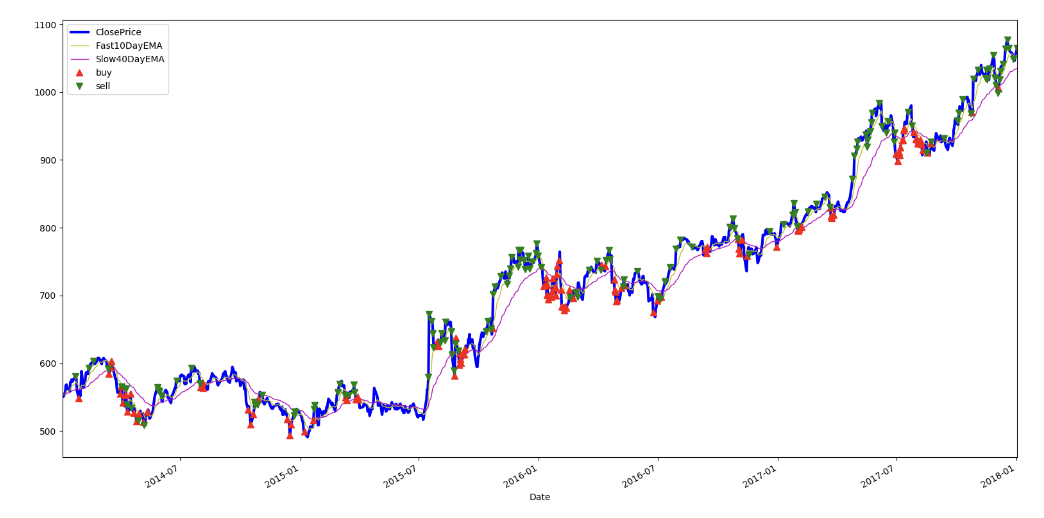

In [1]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.43.03 AM.png")

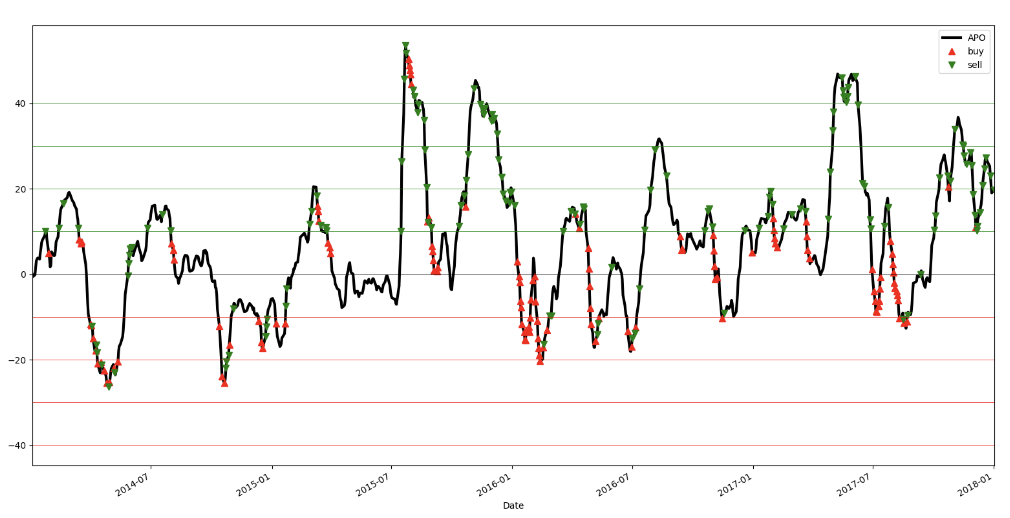

In [2]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.43.22 AM.png")

In [ ]:
# Define a reusable function for plotting Positions and PnL
def plot_data_positions_pnl(data, indicator, marker_flat='.', marker_long='+', marker_short='_', marker_pnl='.'):
    data[indicator].plot(color='k', lw=1., legend=True)
    if indicator == 'Position':
        plt.plot(data.loc[data.Position == 0].index, data.Position[data.Position == 0], color='k', lw=0, marker=marker_flat, label='flat')
        plt.plot(data.loc[data.Position > 0].index, data.Position[data.Position > 0], color='r', lw=0, marker=marker_long, label='long')
        plt.plot(data.loc[data.Position < 0].index, data.Position[data.Position < 0], color='g', lw=0, marker=marker_short, label='short')
        plt.axhline(y=0, lw=0.5, color='k')
        for i in range(NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE*25, NUM_SHARES_PER_TRADE*5):
            plt.axhline(y=i, lw=0.5, color='r')
        for i in range(-NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE*25, -NUM_SHARES_PER_TRADE*5):
            plt.axhline(y=i, lw=0.5, color='g')
    else: # indicator == 'Pnl'
        plt.plot(data.loc[data.Pnl > 0].index, data.Pnl[data.Pnl > 0], color='g', lw=0, marker=marker_pnl)
        plt.plot(data.loc[data.Pnl < 0].index, data.Pnl[data.Pnl < 0], color='r', lw=0, marker=marker_pnl)
    plt.legend()
    plt.show()

# Call function for Position and Pnl
plot_data_positions_pnl(data, 'Position')
plot_data_positions_pnl(data, 'Pnl')


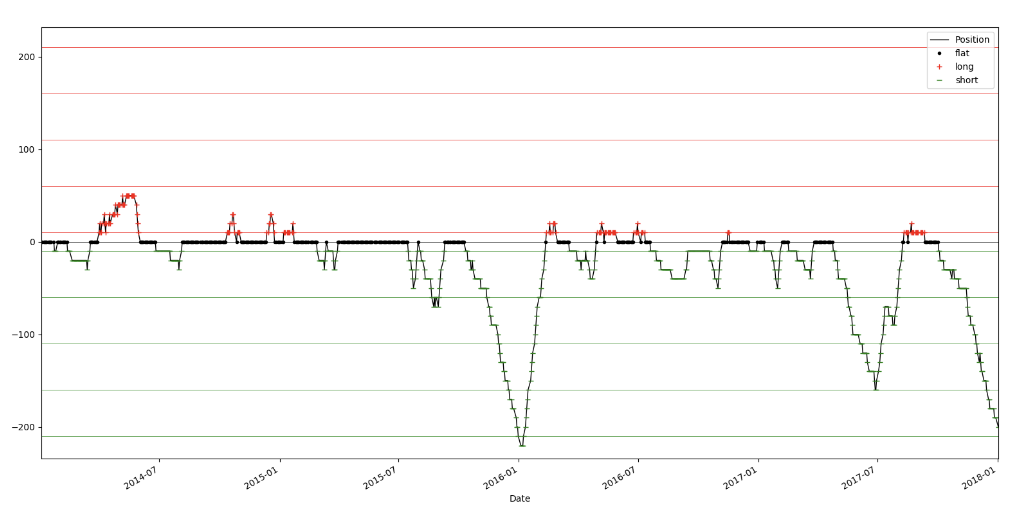

In [3]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.43.49 AM.png")

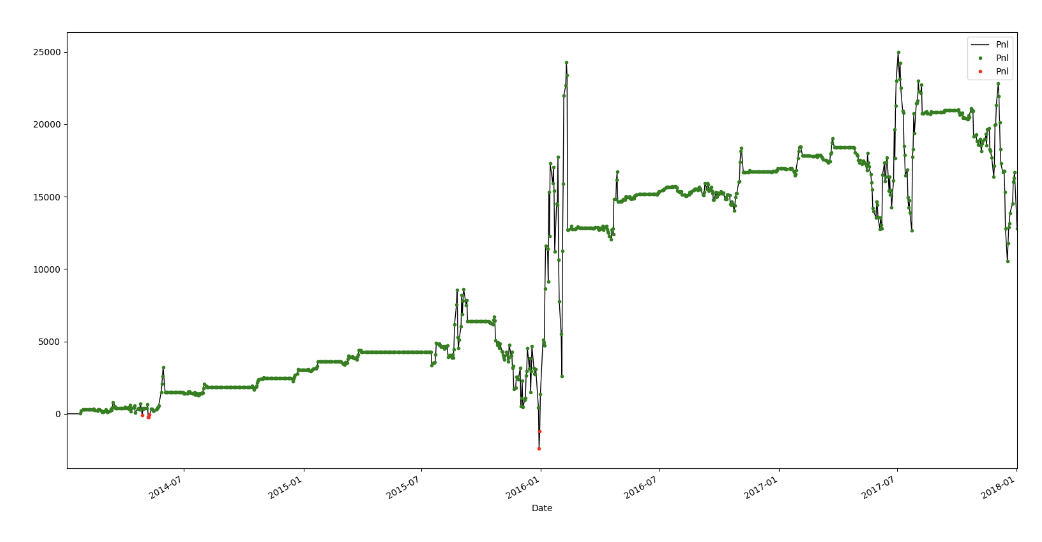

In [4]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.44.21 AM.png")

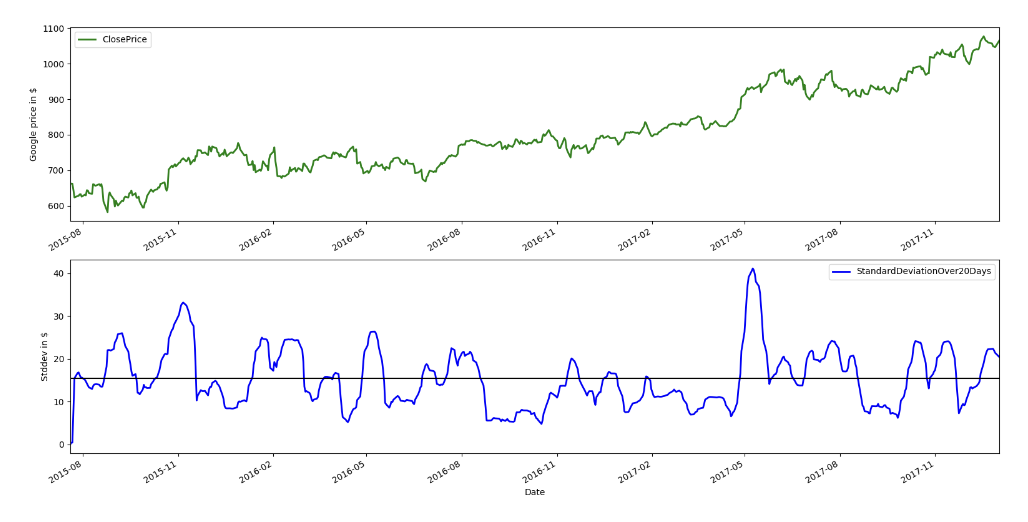

In [5]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.45.10 AM.png")

In [ ]:
import statistics as stats
import math as math

# Define constants and variables for standard deviation computation
SMA_NUM_PERIODS = 20  # Look-back period
price_history = []  # Container for past prices


In [ ]:
# Fetch close prices from the data
close = data['Close']

# Iterate over the close prices
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > SMA_NUM_PERIODS:  # Retain only the latest 'SMA_NUM_PERIODS' prices
        price_history.pop(0)

    sma = stats.mean(price_history)  # Calculate the simple moving average (SMA)
    variance = sum((hist_price - sma) ** 2 for hist_price in price_history)  # Calculate variance

    stdev = math.sqrt(variance / len(price_history))  # Standard deviation
    stdev_factor = stdev / 15 if stdev != 0 else 1  # Standard deviation factor

    # Update fast and slow EMA and compute APO trading signal
    if not ema_fast:  # Check if it's the first observation
        ema_fast = ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * K_FAST * stdev_factor + ema_fast
        ema_slow = (close_price - ema_slow) * K_SLOW * stdev_factor + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow  # Calculate APO
    apo_values.append(apo)


In [ ]:
# Define conditions for sell trade
sell_condition_1 = apo > APO_VALUE_FOR_SELL_ENTRY * stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor
sell_condition_2 = position > 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor)

# Execute a sell trade if the conditions are met
if sell_condition_1 or sell_condition_2:
    orders.append(-1)  # Mark the sell trade
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE  # Update position
    sell_sum_price_qty += close_price * NUM_SHARES_PER_TRADE  # Update vwap sell-price
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print(f"Sell {NUM_SHARES_PER_TRADE} @ {close_price}, Position: {position}")


In [ ]:
# Define conditions for buy trade
buy_condition_1 = apo < APO_VALUE_FOR_BUY_ENTRY * stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE * stdev_factor
buy_condition_2 = position < 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE / stdev_factor)

# Execute a buy trade if the conditions are met
if buy_condition_1 or buy_condition_2:
    orders.append(1)  # Mark the buy trade
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE  # Update position
    buy_sum_price_qty += close_price * NUM_SHARES_PER_TRADE  # Update vwap buy-price
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print(f"Buy {NUM_SHARES_PER_TRADE} @ {close_price}, Position: {position}")
else:
    # If neither sell nor buy conditions were met, do not trade
    orders.append(0)


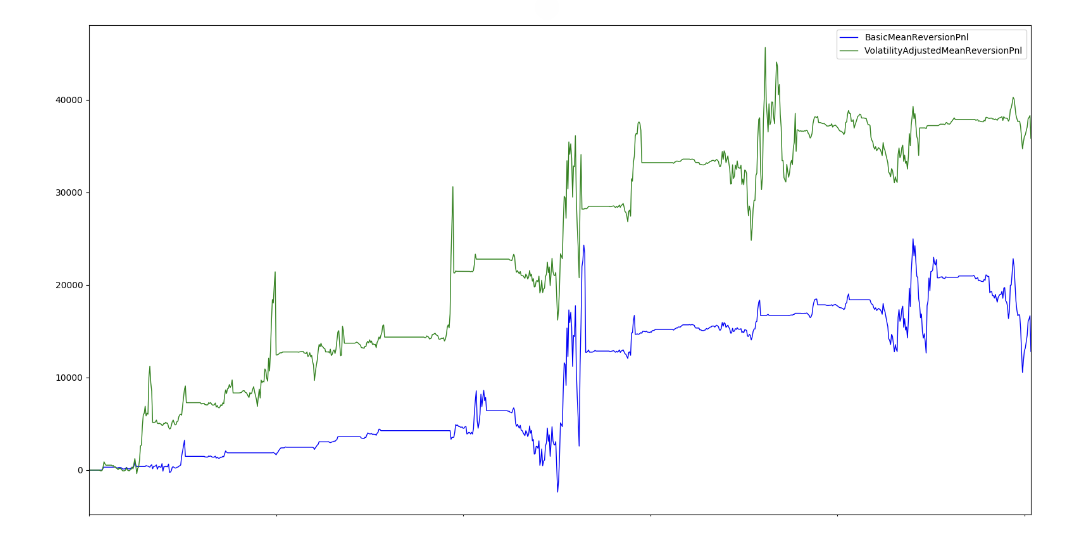

In [6]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.50.48 AM.png")

In [ ]:
# Constants defining strategy behaviors or thresholds
BUY_ENTRY_APO_THRESHOLD = 10 # The APO trading signal value needed to initiate buy-orders or long positions
SELL_ENTRY_APO_THRESHOLD = -10 # The APO trading signal value required to initiate sell-orders or short positions


In [ ]:

  if ((apo < APO_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) # APO above sell entry threshold, we should sell
    or
    (position > 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))): # long from positive APO and APO has gone negative or position is profitable, sell to close position
    orders.append(-1) # mark the sell trade
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE # reduce position by the size of this trade
    sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE) # update vwap sell-price
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print( "Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position )

In [ ]:
elif ((apo > APO_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) 
    or
    (position < 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE))):

    orders.append(+1)
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE
    buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE)
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print("Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)

else:
    orders.append(0)


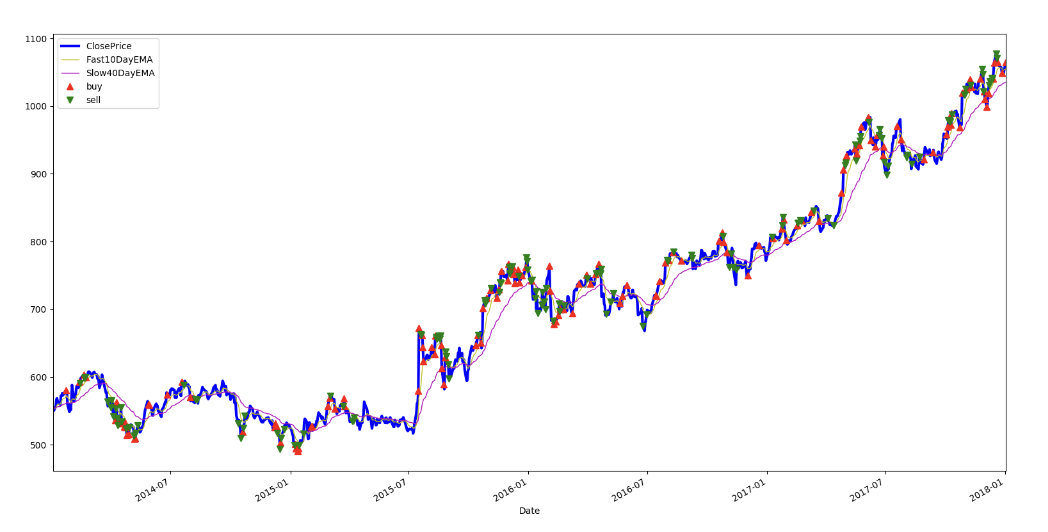

In [7]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.51.47 AM.png")

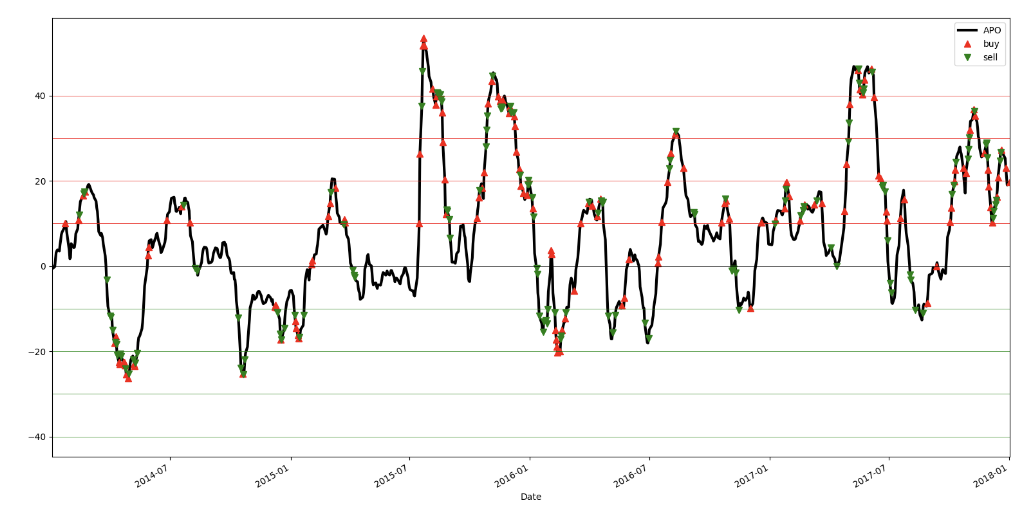

In [8]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.51.57 AM.png")

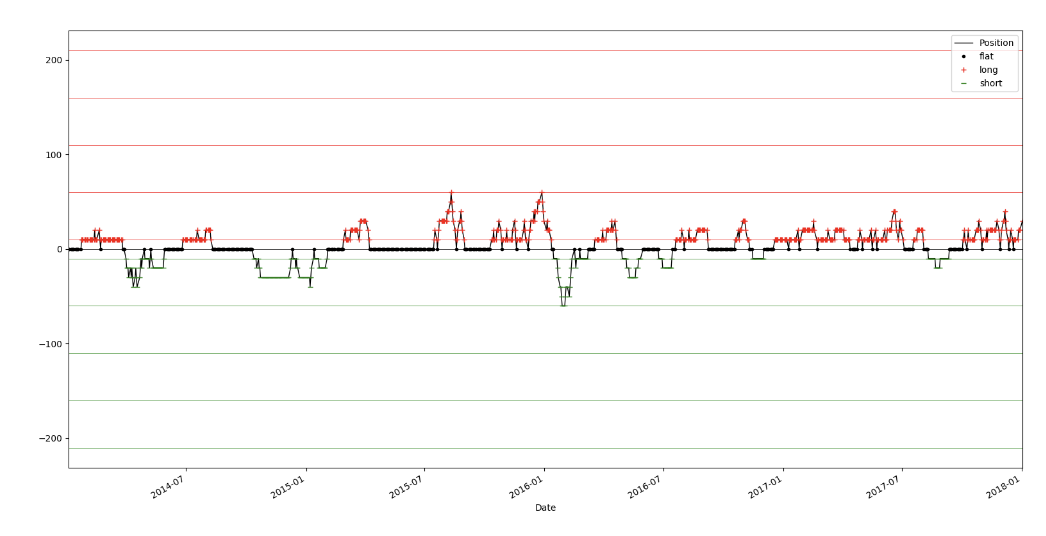

In [9]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.52.27 AM.png")

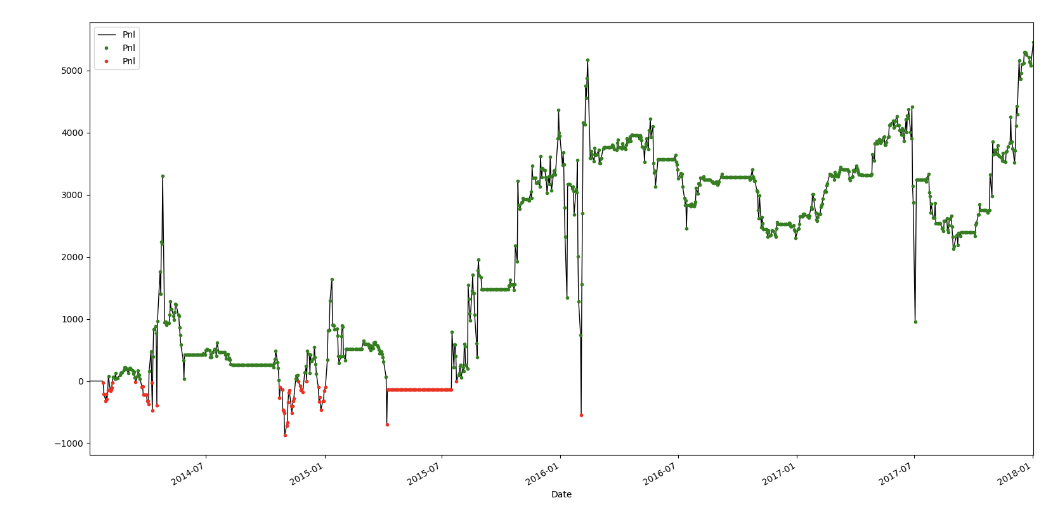

In [10]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.52.39 AM.png")

In [ ]:
if ((apo < APO_VALUE_FOR_SELL_ENTRY/stdev_factor and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor)
    or
    (position > 0 and (apo <= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))):

    orders.append(-1)
    last_sell_price = close_price
    position -= NUM_SHARES_PER_TRADE
    sell_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE)
    sell_sum_qty += NUM_SHARES_PER_TRADE
    print("Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)


In [ ]:
elif ((apo > APO_VALUE_FOR_BUY_ENTRY/stdev_factor and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE*stdev_factor) 
    or
    (position < 0 and (apo >= 0 or open_pnl > MIN_PROFIT_TO_CLOSE/stdev_factor))):

    orders.append(+1)
    last_buy_price = close_price
    position += NUM_SHARES_PER_TRADE
    buy_sum_price_qty += (close_price*NUM_SHARES_PER_TRADE)
    buy_sum_qty += NUM_SHARES_PER_TRADE
    print("Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)

else:
    orders.append(0)


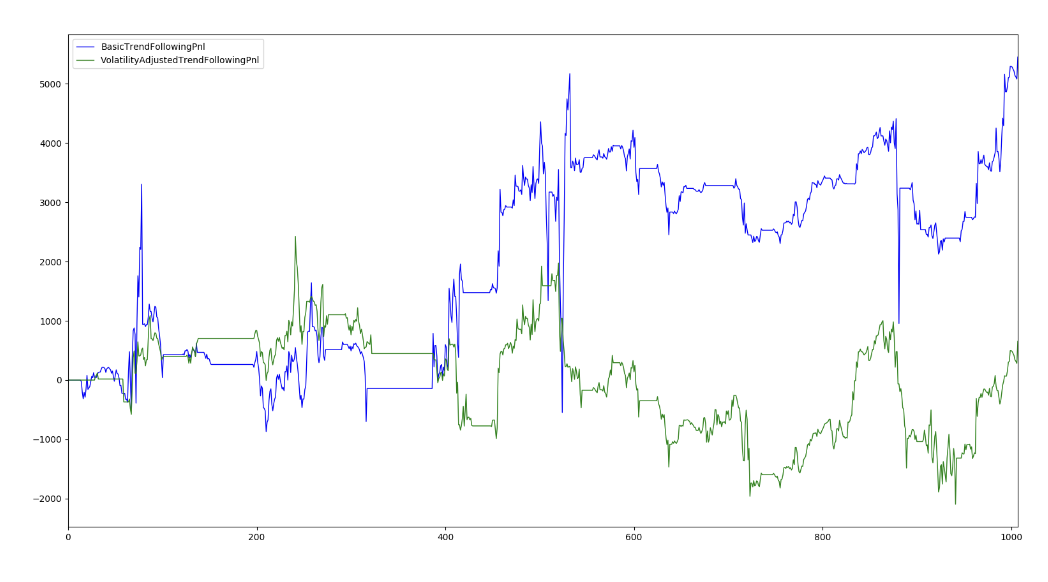

In [11]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.53.23 AM.png")

In [ ]:
Economic release format

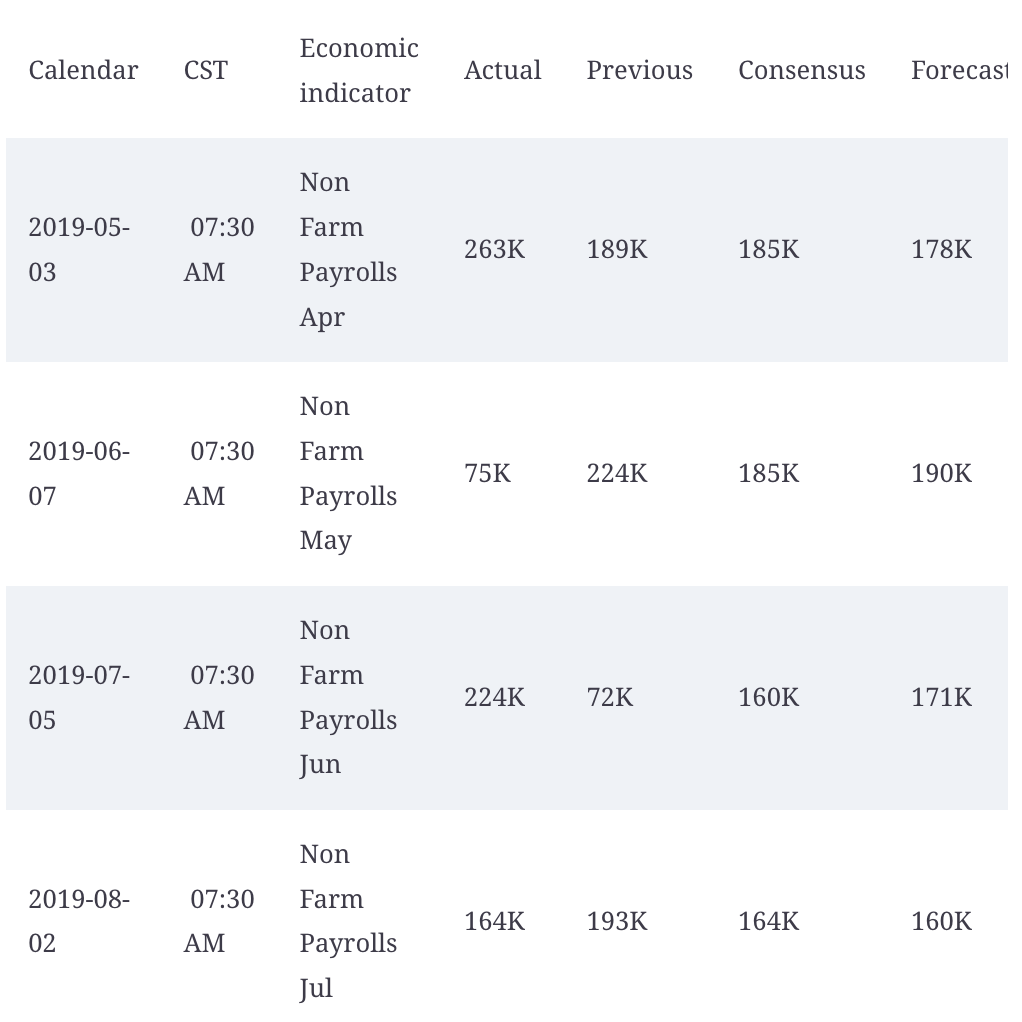

In [12]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.55.03 AM.png")

In [ ]:
Electronic economic release services

In [ ]:
Economic releases in trading

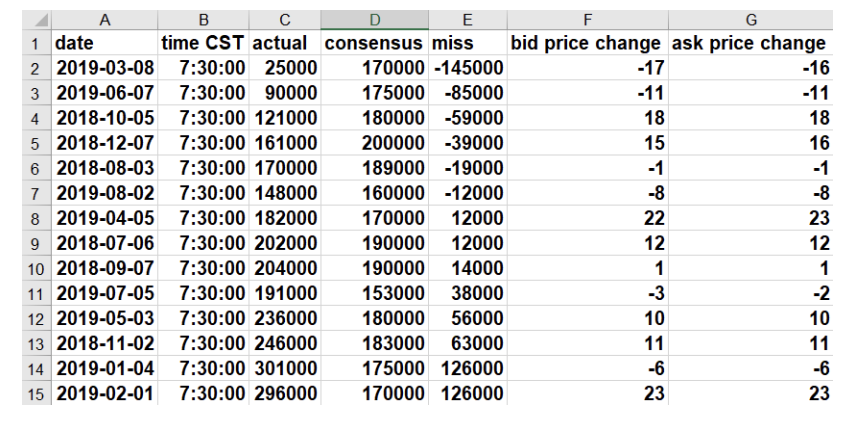

In [13]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.56.03 AM.png")

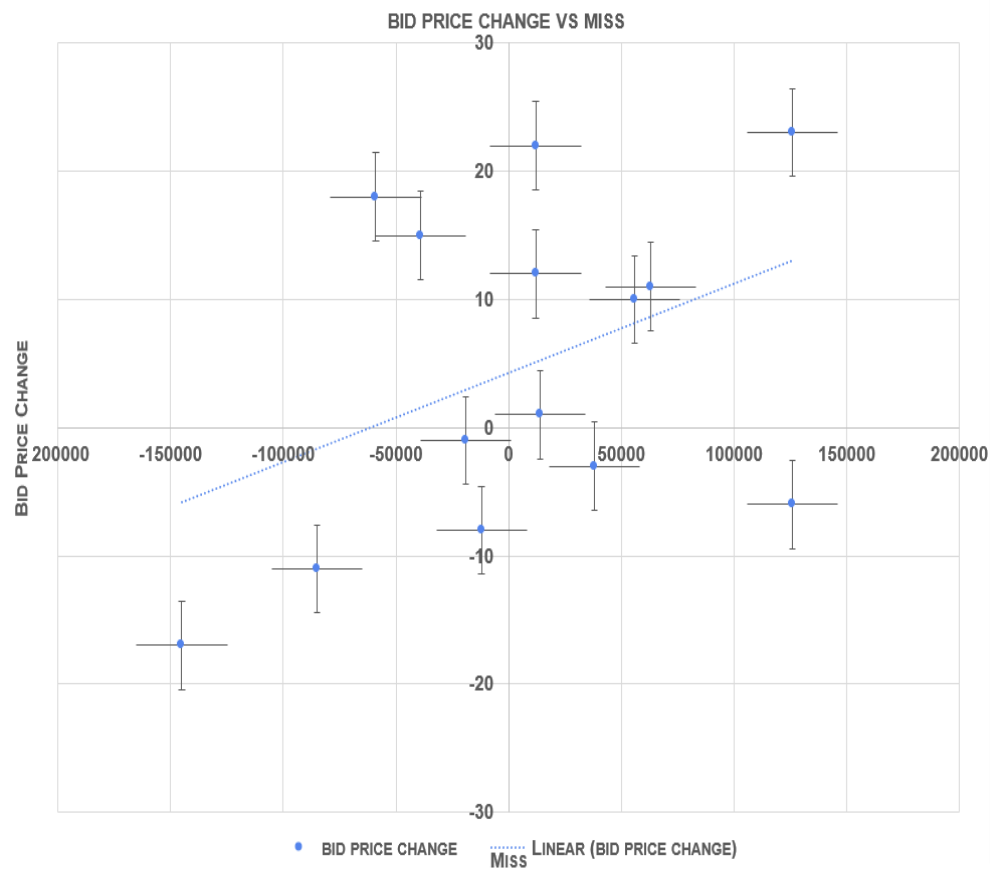

In [14]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.56.23 AM.png")

In [ ]:
Understanding and implementing basic statistical arbitrage trading strategies

In [ ]:
Basics of StatArb

In [ ]:
Lead-lag in StatArb

In [ ]:
StatArb trading strategy in Python

In [ ]:
StatArb data set

In [ ]:
import pandas as pd
from pandas_datareader import data as pdr

TRADING_INSTRUMENT = 'CADUSD=X'
SYMBOLS = ['AUDUSD=X', 'GBPUSD=X', 'CADUSD=X', 'CHFUSD=X', 'EURUSD=X', 'JPYUSD=X', 'NZDUSD=X']
START_DATE = '2014-01-01'
END_DATE = '2018-01-01'

symbols_data = {}

# Fetch data for each symbol
for symbol in SYMBOLS:
    data_file_path = f"{symbol}_data.pkl"

    # Attempt to read local file. If not existent, fetch data from Yahoo Finance
    try:
        symbol_data = pd.read_pickle(data_file_path)
    except FileNotFoundError:
        symbol_data = pdr.get_data_yahoo(symbol, start=START_DATE, end=END_DATE)
        symbol_data.to_pickle(data_file_path)
    
    symbols_data[symbol] = symbol_data


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

price_data = pd.DataFrame()

for symbol in SYMBOLS:
    multiplier = 100.0 if symbol == 'JPYUSD=X' else 1.0

    label = f'{symbol} ClosePrice'
    price_data[label] = symbols_data[symbol]['Close'] * multiplier

# Set the color cycle
colors = ['b', 'g', 'r', 'c', 'm', 'k', 'y']
plt.gca().set_prop_cycle('color', colors)

# Plot each column with its label
for column in price_data:
    plt.plot(price_data.index, price_data[column], lw=2., label=column)

plt.xlabel('Date', fontsize=18)
plt.ylabel('Scaled Price', fontsize=18)
plt.legend(prop={'size': 18})
plt.show()


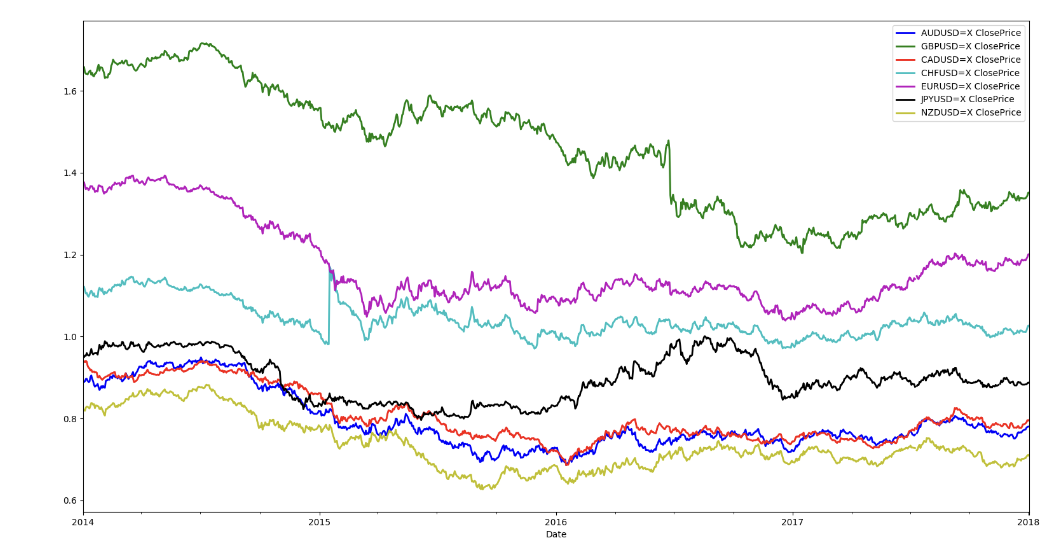

In [15]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 3.58.34 AM.png")

In [ ]:
Defining StatArb signal parameters

In [ ]:
import statistics as stats

SMA_NUM_PERIODS = 20
price_history = {}

PRICE_DEV_NUM_PRICES = 200
price_deviation_from_sma = {}

num_days = len(symbols_data[TRADING_INSTRUMENT].index)
correlation_history = {}
delta_projected_actual_history = {}

final_delta_projected_history = []


In [ ]:
Defining StatArb trading parameters

In [ ]:
import statistics as stats

# Define the necessary constants and containers
SMA_NUM_PERIODS = 20
price_history = {}
PRICE_DEV_NUM_PRICES = 200
price_deviation_from_sma = {}
num_days = len(symbols_data[TRADING_INSTRUMENT].index)
correlation_history = {}
delta_projected_actual_history = {}
final_delta_projected_history = []

# Containers for order and position tracking
orders = []
positions = []
pnls = []

# Trade management variables
last_buy_price = 0
last_sell_price = 0
position = 0
buy_sum_price_qty = 0
buy_sum_qty = 0
sell_sum_price_qty = 0
sell_sum_qty = 0
open_pnl = 0
closed_pnl = 0

# Strategy parameters
StatArb_VALUE_FOR_BUY_ENTRY = 0.01
StatArb_VALUE_FOR_SELL_ENTRY = -0.01
MIN_PRICE_MOVE_FROM_LAST_TRADE = 0.01
NUM_SHARES_PER_TRADE = 1000000
MIN_PROFIT_TO_CLOSE = 10


In [ ]:
Quantifying and computing StatArb trading signals


In [ ]:
for i in range(num_days):
    close_prices = {}

    # Generate ClosePrice series, calculate SMA for each symbol, and compute price-deviation from SMA for each symbol
    for symbol in SYMBOLS:
        close_prices[symbol] = symbols_data[symbol]['Close'].iloc[i]

        # Initialize if symbol not in keys
        if symbol not in price_history:
            price_history[symbol] = []
            price_deviation_from_sma[symbol] = []

        price_history[symbol].append(close_prices[symbol])

        # Maintain most recent prices up to SMA_NUM_PERIODS
        if len(price_history[symbol]) > SMA_NUM_PERIODS:
            price_history[symbol].pop(0)

        # Calculate Simple Moving Average and deviation from it
        sma = stats.mean(price_history[symbol])
        price_deviation_from_sma[symbol].append(close_prices[symbol] - sma)

        # Maintain recent price deviations up to PRICE_DEV_NUM_PRICES
        if len(price_deviation_from_sma[symbol]) > PRICE_DEV_NUM_PRICES:
            price_deviation_from_sma[symbol].pop(0)


In [ ]:
projected_dev_from_sma_using = {}

for symbol in SYMBOLS:
    if symbol == TRADING_INSTRUMENT: # Skip the comparison with itself
        continue

    correlation_label = TRADING_INSTRUMENT + '<-' + symbol

    # Initialize if first entry for this pair in the history dictionary
    if correlation_label not in correlation_history:
        correlation_history[correlation_label] = []
        delta_projected_actual_history[correlation_label] = []

    # Need at least two observations to compute covariance/correlation
    if len(price_deviation_from_sma[symbol]) < 2: 
        correlation_history[correlation_label].append(0)
        delta_projected_actual_history[correlation_label].append(0)
        continue


In [ ]:
  corr = np.corrcoef(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
    cov = np.cov(price_deviation_from_sma[TRADING_INSTRUMENT], price_deviation_from_sma[symbol])
    corr_trading_instrument_lead_instrument = corr[0, 1] # get the correlation between the 2 series
    cov_trading_instrument_lead_instrument = cov[0, 0] / cov[0, 1] # get the covariance between the 2 series

    correlation_history[correlation_label].append(corr_trading_instrument_lead_instrument)


In [ ]:

projected_dev_from_sma_using[symbol] = price_deviation_from_sma[symbol][-1] * cov_trading_instrument_lead_instrument


delta_projected_actual = (projected_dev_from_sma_using[symbol] - price_deviation_from_sma[TRADING_INSTRUMENT][-1])

delta_projected_actual_history[correlation_label].append(delta_projected_actual)


In [ ]:
# Calculate the sum of weights, which is the sum of correlations for each symbol with TRADING_INSTRUMENT
sum_weights = sum(abs(correlation_history[TRADING_INSTRUMENT + '<-' + symbol][-1]) for symbol in SYMBOLS if symbol != TRADING_INSTRUMENT)

# Initialize final prediction of price deviation in TRADING_INSTRUMENT
final_delta_projected = 0
close_price = close_prices[TRADING_INSTRUMENT]

# Iterate over symbols to weight projections by correlation
for symbol in SYMBOLS:
    if symbol != TRADING_INSTRUMENT:
        correlation_label = TRADING_INSTRUMENT + '<-' + symbol
        final_delta_projected += abs(correlation_history[correlation_label][-1]) * delta_projected_actual_history[correlation_label][-1]

# Normalize final_delta_projected by sum of weights
final_delta_projected = final_delta_projected / sum_weights if sum_weights != 0 else 0

# Append the final delta projection to history
final_delta_projected_history.append(final_delta_projected)


In [ ]:
StatArb execution logic

In [ ]:
# Check if we should execute a sell trade
if (final_delta_projected < StatArb_VALUE_FOR_SELL_ENTRY and abs(close_price - last_sell_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) or \
   (position > 0 and open_pnl > MIN_PROFIT_TO_CLOSE):
    orders.append(-1)  # Append -1 to orders list to indicate a sell order
    last_sell_price = close_price  # Update the last sell price
    position -= NUM_SHARES_PER_TRADE  # Update the position after selling
    sell_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  # Update the volume weighted average price for sell
    sell_sum_qty += NUM_SHARES_PER_TRADE  # Update the quantity sold
    print("Sell ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
    print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))


In [ ]:
# Check if we should execute a buy trade
elif (final_delta_projected > StatArb_VALUE_FOR_BUY_ENTRY and abs(close_price - last_buy_price) > MIN_PRICE_MOVE_FROM_LAST_TRADE) or \
     (position < 0 and open_pnl > MIN_PROFIT_TO_CLOSE):
    orders.append(+1)  # Append +1 to orders list to indicate a buy order
    last_buy_price = close_price  # Update the last buy price
    position += NUM_SHARES_PER_TRADE  # Update the position after buying
    buy_sum_price_qty += (close_price * NUM_SHARES_PER_TRADE)  # Update the volume weighted average price for buy
    buy_sum_qty += NUM_SHARES_PER_TRADE  # Update the quantity bought
    print("Buy ", NUM_SHARES_PER_TRADE, " @ ", close_price, "Position: ", position)
    print("OpenPnL: ", open_pnl, " ClosedPnL: ", closed_pnl, " TotalPnL: ", (open_pnl + closed_pnl))

# If no conditions were met to execute a buy or sell order
else:
    orders.append(0)  # Append 0 to orders list to indicate no action
positions.append(position)  # Update the positions list with the current position


In [ ]:

  open_pnl = 0
  if position > 0:
    if sell_sum_qty > 0: 
      open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
    
    open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
  elif position < 0:
    if buy_sum_qty > 0:
      open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty / sell_sum_qty - buy_sum_price_qty / buy_sum_qty)
    
    open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty / sell_sum_qty - close_price)
  else:
   
    closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
    buy_sum_price_qty = 0
    buy_sum_qty = 0
    sell_sum_price_qty = 0
    sell_sum_qty = 0
    last_buy_price = 0
    last_sell_price = 0

  pnls.append(closed_pnl + open_pnl)

In [ ]:
StatArb signal and strategy performance analysis

In [ ]:

correlation_data = pd.DataFrame()
for symbol in SYMBOLS:
  if symbol == TRADING_INSTRUMENT:
    continue

  correlation_label = TRADING_INSTRUMENT + '<-' + symbol
  correlation_data = correlation_data.assign(label=pd.Series(correlation_history[correlation_label], index=symbols_data[symbol].index))
  ax = correlation_data['label'].plot(color=next(cycol), lw=2., label='Correlation ' + correlation_label)

for i in np.arange(-1, 1, 0.25):
  plt.axhline(y=i, lw=0.5, color='k')
plt.legend()
plt.show()

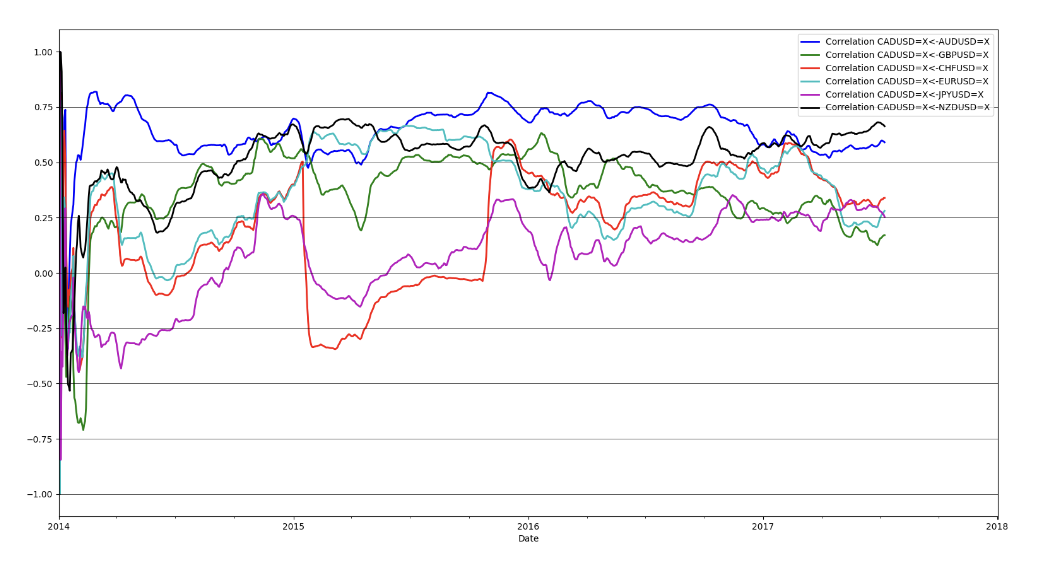

In [16]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 4.01.50 AM.png")

In [ ]:

delta_projected_actual_data = pd.DataFrame()
for symbol in SYMBOLS:
  if symbol == TRADING_INSTRUMENT:
    continue

  projection_label = TRADING_INSTRUMENT + '<-' + symbol
  delta_projected_actual_data = delta_projected_actual_data.assign(StatArbTradingSignal=pd.Series(delta_projected_actual_history[projection_label], index=symbols_data[TRADING_INSTRUMENT].index))
  ax = delta_projected_actual_data['StatArbTradingSignal'].plot(color=next(cycol), lw=1., label='StatArbTradingSignal ' + projection_label)
plt.legend()
plt.show()

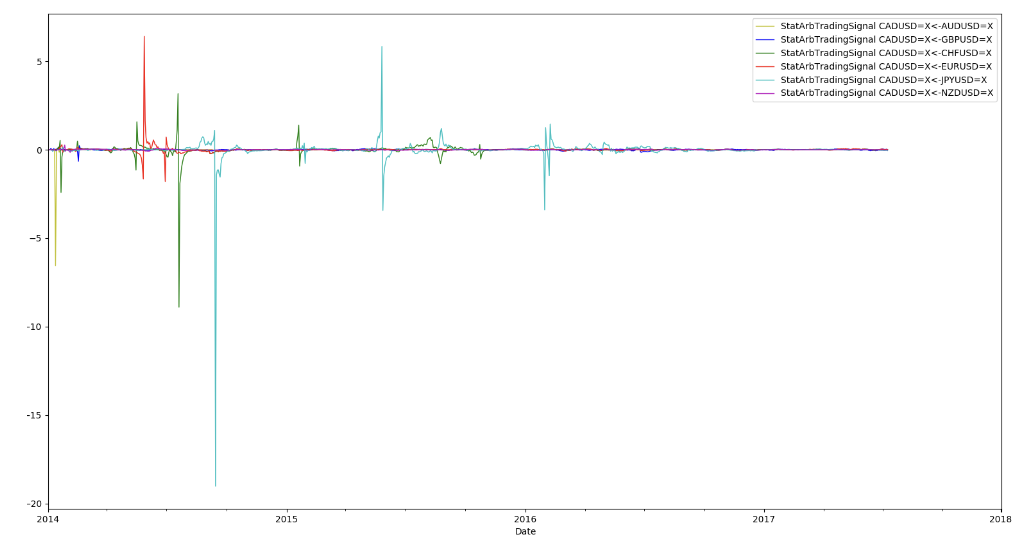

In [17]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 4.02.09 AM.png")

In [ ]:
trading_data = symbols_data[TRADING_INSTRUMENT]
delta_proj_act_data = delta_projected_actual_data

# Assign new columns to the DataFrame
new_cols = {
    'ClosePrice': trading_data['Close'],
    'FinalStatArbTradingSignal': pd.Series(final_delta_projected_history, index=trading_data.index),
    'Trades': pd.Series(orders, index=trading_data.index),
    'Position': pd.Series(positions, index=trading_data.index),
    'Pnl': pd.Series(pnls, index=trading_data.index),
}

for col_name, col_data in new_cols.items():
    delta_proj_act_data = delta_proj_act_data.assign(**{col_name: col_data})

# Set up markers for buy and sell
buy_markers = delta_proj_act_data.Trades == 1
sell_markers = delta_proj_act_data.Trades == -1

# Plotting the data
plt.plot(delta_proj_act_data.index, delta_proj_act_data.ClosePrice, color='k', lw=1., label='ClosePrice')
plt.plot(delta_proj_act_data[buy_markers].index, delta_proj_act_data.ClosePrice[buy_markers], 'r^', markersize=7, label='buy')
plt.plot(delta_proj_act_data[sell_markers].index, delta_proj_act_data.ClosePrice[sell_markers], 'gv', markersize=7, label='sell')
plt.legend()
plt.show()


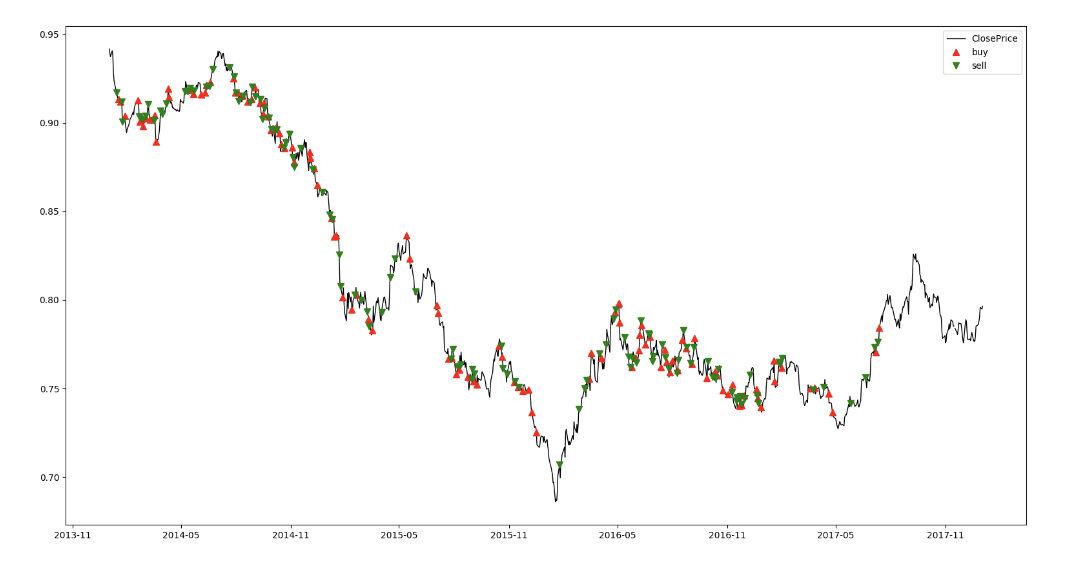

In [18]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 4.03.28 AM.png")

In [ ]:
plt.plot(delta_projected_actual_data.index, delta_projected_actual_data.FinalStatArbTradingSignal, color='k', lw=1., label='FinalStatArbTradingSignal')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == 1].index, delta_projected_actual_data.FinalStatArbTradingSignal[delta_projected_actual_data.Trades == 1], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(delta_projected_actual_data.loc[delta_projected_actual_data.Trades == -1].index, delta_projected_actual_data.FinalStatArbTradingSignal[delta_projected_actual_data.Trades == -1], color='g', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')
for i in np.arange(StatArb_VALUE_FOR_BUY_ENTRY, StatArb_VALUE_FOR_BUY_ENTRY * 10, StatArb_VALUE_FOR_BUY_ENTRY * 2):
  plt.axhline(y=i, lw=0.5, color='r')
for i in np.arange(StatArb_VALUE_FOR_SELL_ENTRY, StatArb_VALUE_FOR_SELL_ENTRY * 10, StatArb_VALUE_FOR_SELL_ENTRY * 2):
  plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.show()

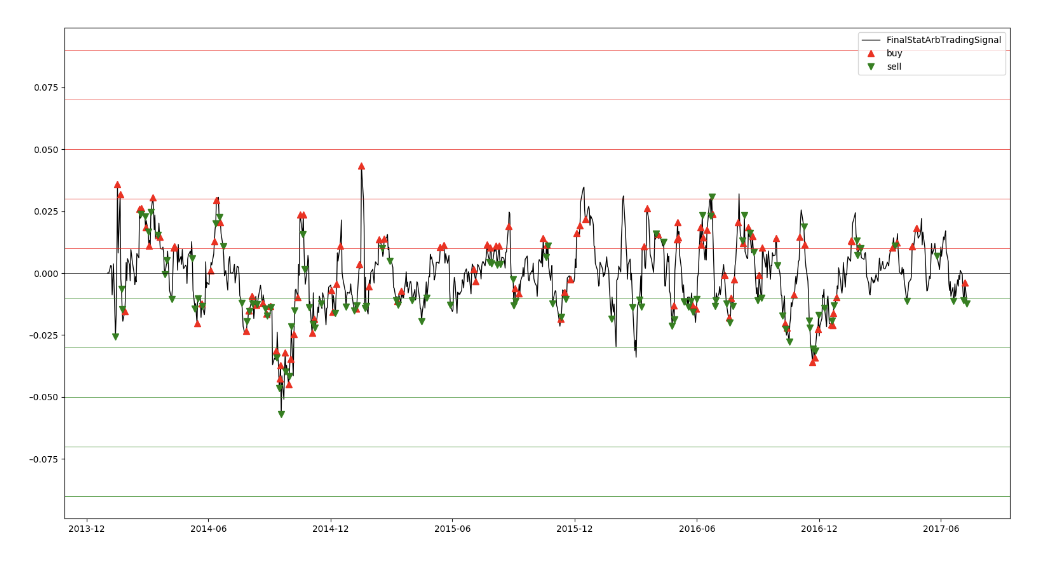

In [19]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 4.03.48 AM.png")

In [ ]:
delta_proj_act_data = delta_projected_actual_data
positions = delta_proj_act_data.Position
index = delta_proj_act_data.index

# Set up markers for positions
flat_markers = positions == 0
long_markers = positions > 0
short_markers = positions < 0

# Plotting the data
plt.plot(index, positions, color='k', lw=1., label='Position')
plt.plot(index[flat_markers], positions[flat_markers], 'k.', label='flat')
plt.plot(index[long_markers], positions[long_markers], 'r+', label='long')
plt.plot(index[short_markers], positions[short_markers], 'g_', label='short')

plt.axhline(y=0, lw=0.5, color='k')

# Plotting horizontal lines
for i in range(NUM_SHARES_PER_TRADE, NUM_SHARES_PER_TRADE * 5, NUM_SHARES_PER_TRADE):
  plt.axhline(y=i, lw=0.5, color='r')
for i in range(-NUM_SHARES_PER_TRADE, -NUM_SHARES_PER_TRADE * 5, -NUM_SHARES_PER_TRADE):
  plt.axhline(y=i, lw=0.5, color='g')

plt.legend()
plt.show()


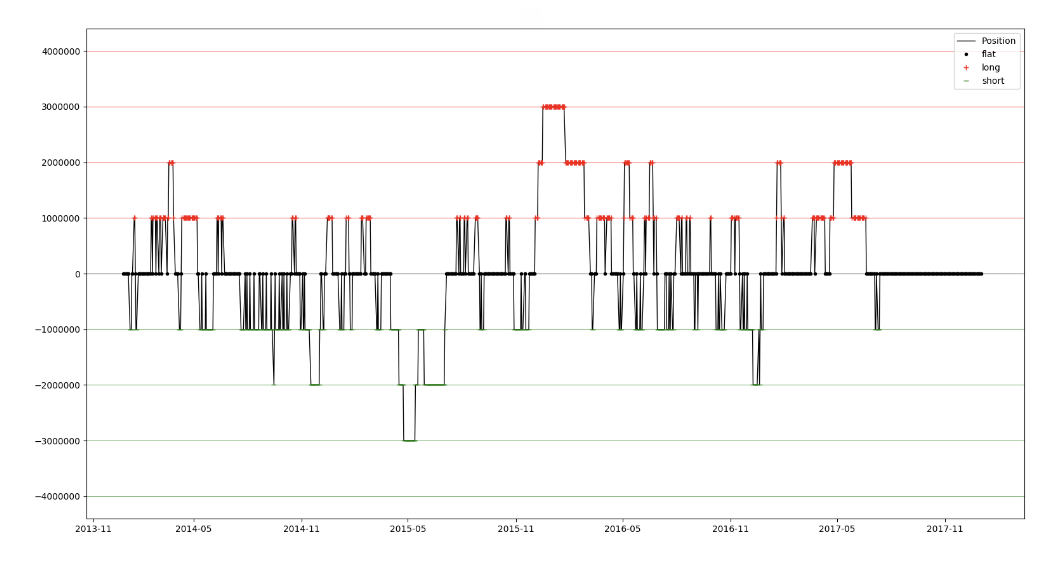

In [20]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 4.04.16 AM.png")

In [ ]:
delta_proj_act_data = delta_projected_actual_data
pnl = delta_proj_act_data.Pnl
index = delta_proj_act_data.index

# Set up markers for PnL
positive_pnl_markers = pnl > 0
negative_pnl_markers = pnl < 0

# Plotting the data
plt.plot(index, pnl, color='k', lw=1., label='Pnl')
plt.plot(index[positive_pnl_markers], pnl[positive_pnl_markers], 'g.', label='Positive Pnl')
plt.plot(index[negative_pnl_markers], pnl[negative_pnl_markers], 'r.', label='Negative Pnl')

plt.legend()
plt.show()


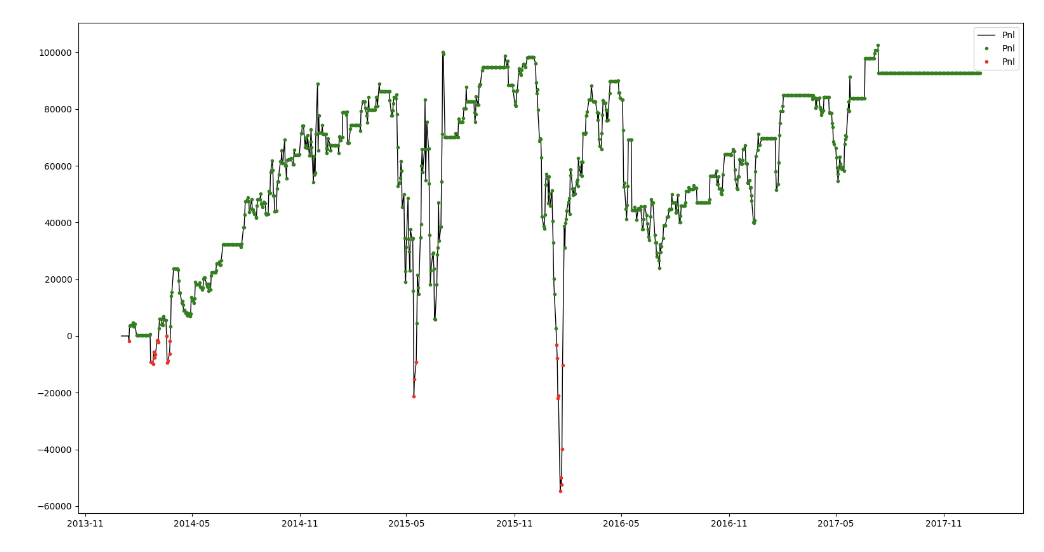

In [21]:
from IPython.display import Image
Image(filename="Screenshot 2023-07-25 at 4.04.30 AM.png")